# Access AWS CESM2 using the AWS open data origin data and benchmark

In [33]:
import intake
import numpy as np
import pandas as pd
import xarray as xr
import re
import aiohttp
import time
from contextlib import contextmanager
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import fsspec.implementations.http as fshttp
from pelicanfs.core import PelicanFileSystem, PelicanMap, OSDFFileSystem 

In [3]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [4]:
init_year0  = '1991'
init_year1  = '2020'
final_year0 = '2071'
final_year1 = '2100'

In [5]:
# # This overwrites the default scheduler with a single-threaded scheduler
# dask.config.set(scheduler='synchronous')  

In [6]:
# File paths
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
#
rda_url        =  'https://data.rda.ucar.edu/'
intake_url     = rda_url + 'harshah/intake_catalogs/cesm2-lens-osdf/aws-cesm2-le.json'
aws_intake_url = 'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'

### Create a Dask cluster

#### Select the Dask cluster type
The default will be LocalCluster as that can run on any system.

If running on a HPC computer with a PBS Scheduler, set to True. Otherwise, set to False.

In [7]:
USE_PBS_SCHEDULER = False

If running on Jupyter server with Dask Gateway configured, set to True. Otherwise, set to False.

In [8]:
USE_DASK_GATEWAY = False

#### Python function for a PBS cluster

In [9]:
# Create a PBS cluster object
def get_pbs_cluster():
    """ Create cluster through dask_jobqueue.   
    """
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(
        job_name = 'dask-osdf-24',
        cores = 1,
        memory = '4GiB',
        processes = 1,
        local_directory = rda_scratch + '/dask/spill',
        log_directory = rda_scratch + '/dask/logs/',
        resource_spec = 'select=1:ncpus=1:mem=4GB',
        queue = 'casper',
        walltime = '3:00:00',
        #interface = 'ib0'
        interface = 'ext'
    )
    return cluster

#### Python function for a Gateway Cluster

In [10]:
def get_gateway_cluster():
    """ Create cluster through dask_gateway
    """
    from dask_gateway import Gateway

    gateway = Gateway()
    cluster = gateway.new_cluster()
    cluster.adapt(minimum=2, maximum=4)
    return cluster

#### Python function for a Local Cluster

In [11]:
def get_local_cluster():
    """ Create cluster using the Jupyter server's resources
    """
    from distributed import LocalCluster, performance_report
    cluster = LocalCluster()    

    cluster.scale(4)
    return cluster

This uses True/False boolean logic based on the variables set in the previous cells

#### Python logic to select the Dask Cluster type

In [12]:
# Obtain dask cluster in one of three ways

if USE_PBS_SCHEDULER:
    cluster = get_pbs_cluster()
elif USE_DASK_GATEWAY:
    cluster = get_gateway_cluster()
else:
    cluster = get_local_cluster()

# Connect to cluster
from distributed import Client
client = Client(cluster)

In [13]:
# Scale the cluster and display cluster dashboard URL
# cluster.scale(4)
cluster

LocalCluster(84e948de, 'tcp://127.0.0.1:43357', workers=4, threads=4, memory=16.00 GiB)

## Access the data from the AWS bucket using intake

In [14]:
osdf_catalog   = intake.open_esm_datastore(intake_url)
https_catalog  = intake.open_esm_datastore(aws_intake_url)
osdf_catalog

,unique
Unnamed: 0,322
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20


In [15]:
osdf_catalog.df['path'].head().values

array(['osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLNS.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLNSC.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLUT.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FSNS.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FSNSC.zarr'],
      dtype=object)

In [16]:
https_catalog.df['path'].head().values

array(['s3://ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLNS.zarr',
       's3://ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLNSC.zarr',
       's3://ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLUT.zarr',
       's3://ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FSNS.zarr',
       's3://ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FSNSC.zarr'],
      dtype=object)

In [17]:
osdf_catalog_temp   = osdf_catalog.search(variable ='TREFHTMX', frequency ='daily')
https_catalog_temp  = https_catalog.search(variable ='TREFHTMX', frequency ='daily')
https_catalog_temp

,unique
variable,1
long_name,1
component,1
experiment,2
forcing_variant,2
frequency,1
vertical_levels,1
spatial_domain,1
units,1
start_time,2


In [18]:
%%time
#dsets = osdf_catalog_temp.to_dataset_dict(storage_options={'anon':True})
dsets_osdf  = osdf_catalog_temp.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


CPU times: user 1.79 s, sys: 239 ms, total: 2.03 s
Wall time: 29.1 s


In [19]:
dsets_https = https_catalog_temp.to_dataset_dict(storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


In [20]:
%%time
dsets_osdf.keys()

CPU times: user 4 μs, sys: 1 μs, total: 5 μs
Wall time: 6.44 μs


dict_keys(['atm.historical.daily.smbb', 'atm.ssp370.daily.cmip6', 'atm.ssp370.daily.smbb', 'atm.historical.daily.cmip6'])

In [21]:
ds_osdf    = dsets_osdf['atm.historical.daily.smbb']
ds_https   = dsets_https['atm.historical.daily.smbb']
#
ds_osdf    = ds_osdf.TREFHTMX
ds_https   = ds_https.TREFHTMX
ds_osdf

<xarray.DataArray 'TREFHTMX' (member_id: 50, time: 60225, lat: 192, lon: 288)> Size: 666GB
dask.array<open_dataset-TREFHTMX, shape=(50, 60225, 192, 288), dtype=float32, chunksize=(1, 730, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1191p1f2' ... 'r9i1171p1f2'
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

## Data Access Speed tests
- We will now test how long it takes to access data (via OSDF) for various sizes using one of the above arrays

### Prepare data subsets

In [22]:
ds_osdf_1Kb  = ds_osdf.isel(lat=0,lon=0,member_id=0).isel(time=np.arange(260))
ds_https_1Kb = ds_https.isel(lat=0,lon=0,member_id=0).isel(time=np.arange(260))
ds_osdf_1Kb

<xarray.DataArray 'TREFHTMX' (time: 260)> Size: 1kB
dask.array<getitem, shape=(260,), dtype=float32, chunksize=(260,), chunktype=numpy.ndarray>
Coordinates:
    lat        float64 8B -90.0
    lon        float64 8B 0.0
    member_id  <U12 48B 'r10i1191p1f2'
  * time       (time) object 2kB 1850-01-01 12:00:00 ... 1850-09-17 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [23]:
ds_osdf_1Mb  = ds_osdf.isel(time=0).isel(member_id =1+ np.arange(5))
ds_https_1Mb = ds_https.isel(time=0).isel(member_id =1+ np.arange(5))
ds_osdf_1Mb

<xarray.DataArray 'TREFHTMX' (member_id: 5, lat: 192, lon: 288)> Size: 1MB
dask.array<getitem, shape=(5, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 240B 'r11i1231p1f2' ... 'r12i1231p1f2'
    time       object 8B 1850-01-01 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [24]:
ds_osdf_10Mb  = ds_osdf.isel(member_id =6).isel(time=np.arange(48))
ds_https_10Mb = ds_https.isel(member_id =6).isel(time=np.arange(48))
ds_osdf_10Mb

<xarray.DataArray 'TREFHTMX' (time: 48, lat: 192, lon: 288)> Size: 11MB
dask.array<getitem, shape=(48, 192, 288), dtype=float32, chunksize=(48, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    member_id  <U12 48B 'r12i1251p1f2'
  * time       (time) object 384B 1850-01-01 12:00:00 ... 1850-02-17 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [25]:
ds_osdf_100Mb  = ds_osdf.isel(member_id =7).isel(time=np.arange(480))
ds_https_100Mb = ds_https.isel(member_id =7).isel(time=np.arange(480))
ds_osdf_100Mb

<xarray.DataArray 'TREFHTMX' (time: 480, lat: 192, lon: 288)> Size: 106MB
dask.array<getitem, shape=(480, 192, 288), dtype=float32, chunksize=(480, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    member_id  <U12 48B 'r12i1281p1f2'
  * time       (time) object 4kB 1850-01-01 12:00:00 ... 1851-04-25 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [26]:
ds_osdf_1Gb  = ds_osdf.isel(member_id  = 8 + np.arange(6)).isel(time = np.arange(810))
ds_https_1Gb = ds_https.isel(member_id = 8 + np.arange(6)).isel(time = np.arange(810))
ds_osdf_1Gb

<xarray.DataArray 'TREFHTMX' (member_id: 6, time: 810, lat: 192, lon: 288)> Size: 1GB
dask.array<getitem, shape=(6, 810, 192, 288), dtype=float32, chunksize=(1, 730, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 288B 'r12i1301p1f2' ... 'r14i1231p1f2'
  * time       (time) object 6kB 1850-01-01 12:00:00 ... 1852-03-21 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [27]:
ds_osdf_10Gb  = ds_osdf.isel(member_id  = 15)
ds_https_10Gb = ds_https.isel(member_id = 15)
ds_osdf_10Gb

<xarray.DataArray 'TREFHTMX' (time: 60225, lat: 192, lon: 288)> Size: 13GB
dask.array<getitem, shape=(60225, 192, 288), dtype=float32, chunksize=(730, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    member_id  <U12 48B 'r14i1281p1f2'
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

### Now access data and plot

In [28]:
ds_osdf_list  = [ds_osdf_1Kb,ds_osdf_1Mb,ds_osdf_10Mb,ds_osdf_100Mb,ds_osdf_1Gb]
ds_https_list = [ds_https_1Kb,ds_https_1Mb,ds_https_10Mb,ds_https_100Mb,ds_https_1Gb]

In [29]:
# Number of data access calls
num_calls = 5  # Modify this as needed
n_workers = 4  # Set this to your preferred number of workers

# DiagnosticTimer class to keep track of runtimes
class DiagnosticTimer:
    def __init__(self):
        self.diagnostics = []

    @contextmanager
    def time(self, **kwargs):
        tic = time.time()
        yield
        toc = time.time()
        kwargs["runtime"] = toc - tic
        self.diagnostics.append(kwargs)

    def dataframe(self):
        return pd.DataFrame(self.diagnostics)

# Initialize the DiagnosticTimer
diag_timer = DiagnosticTimer()

def benchmark_protocol(datasets, protocol_name, cluster=None):
    for index, dataset in enumerate(datasets):
        # Calculate dataset size in MB for logging
        dataset_size_mb = dataset.nbytes / (1024 ** 2)
        
        # Each dataset will be loaded multiple times to capture caching effect
        for call_num in range(num_calls):
            if cluster is not None:
                # Scale down to zero workers to clear memory
                cluster.scale(0)  # Stop all workers
                cluster.scale(n_workers)  # Scale up to the required number of workers
                client.wait_for_workers(n_workers)  # Wait for the workers to be ready

            # Only count the time for loading dataset into memory, excluding cluster scaling time
            dataset_copy = dataset.copy()
            with diag_timer.time(dataset_size=dataset_size_mb, protocol=protocol_name, call_number=call_num + 1):
                dataset_copy.load()  # Load the dataset into memory
            print(f" Finished processing dataset {index + 1} in {call_num + 1} th call")

In [30]:
# Run benchmark for each protocol
benchmark_protocol(ds_https_list, "HTTPS-only",cluster)
benchmark_protocol(ds_osdf_list, "OSDF-director",cluster)

# Convert diagnostics to a DataFrame for analysis
df_diagnostics = diag_timer.dataframe()

# Calculate MB/s for each run
df_diagnostics['MBps'] = df_diagnostics['dataset_size'] / df_diagnostics['runtime']
df_diagnostics

 Finished processing dataset 1 in 1 th call
 Finished processing dataset 1 in 2 th call
 Finished processing dataset 1 in 3 th call
 Finished processing dataset 1 in 4 th call
 Finished processing dataset 1 in 5 th call
 Finished processing dataset 2 in 1 th call
 Finished processing dataset 2 in 2 th call
 Finished processing dataset 2 in 3 th call


2024-11-13 13:43:35,946 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/glade/work/harshah/conda-envs/arco_experiments/lib/python3.12/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/glade/work/harshah/conda-envs/arco_experiments/lib/python3.12/site-packages/distributed/worker.py", line 1250, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/glade/work/harshah/conda-envs/arco_experiments/lib/python3.12/site-packages/distributed/utils_comm.py", line 459, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/glade/work/harshah/conda-en

 Finished processing dataset 2 in 4 th call
 Finished processing dataset 2 in 5 th call
 Finished processing dataset 3 in 1 th call
 Finished processing dataset 3 in 2 th call
 Finished processing dataset 3 in 3 th call
 Finished processing dataset 3 in 4 th call
 Finished processing dataset 3 in 5 th call
 Finished processing dataset 4 in 1 th call
 Finished processing dataset 4 in 2 th call
 Finished processing dataset 4 in 3 th call
 Finished processing dataset 4 in 4 th call
 Finished processing dataset 4 in 5 th call
 Finished processing dataset 5 in 1 th call
 Finished processing dataset 5 in 2 th call
 Finished processing dataset 5 in 3 th call
 Finished processing dataset 5 in 4 th call
 Finished processing dataset 5 in 5 th call
 Finished processing dataset 1 in 1 th call
 Finished processing dataset 1 in 2 th call
 Finished processing dataset 1 in 3 th call
 Finished processing dataset 1 in 4 th call
 Finished processing dataset 1 in 5 th call
 Finished processing dataset 2 i

,dataset_size,protocol,call_number,runtime,MBps
0,0.000992,HTTPS-only,1,2.956014,0.000336
1,0.000992,HTTPS-only,2,4.895771,0.000203
2,0.000992,HTTPS-only,3,4.906705,0.000202
3,0.000992,HTTPS-only,4,4.891437,0.000203
4,0.000992,HTTPS-only,5,4.900734,0.000202
5,1.054688,HTTPS-only,1,10.828878,0.097396
6,1.054688,HTTPS-only,2,8.343928,0.126402
7,1.054688,HTTPS-only,3,8.601030,0.122623
8,1.054688,HTTPS-only,4,8.225785,0.128217
9,1.054688,HTTPS-only,5,10.546385,0.100005


/glade/derecho/scratch/harshah/tmp/ipykernel_13477/2772681286.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subsequent_access_avg = subsequent_access.groupby('dataset_size')['MBps'].mean()


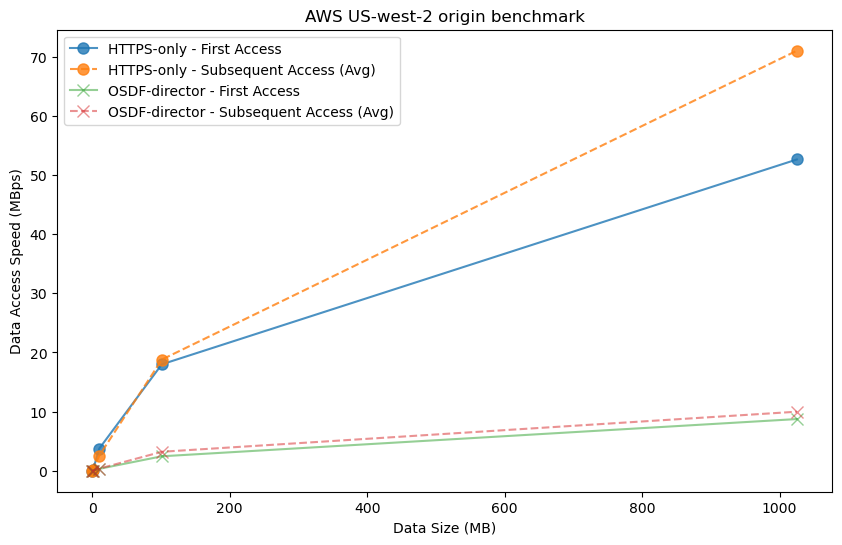

In [36]:
# Plotting MBps vs data size for each protocol and call type
# Define different alpha values for each protocol
alpha_values = {"HTTPS-only": 0.8, "OSDF-director": 0.5}  # Adjust transparency as needed
marker_style = {"HTTPS-only": "o", "OSDF-director": "x"}  # Define different markers for each protocol
#
fig, ax = plt.subplots(figsize=(10, 6))
for protocol in ["HTTPS-only", "OSDF-director"]:
    # First access (call_number == 1)
    first_access = df_diagnostics[(df_diagnostics['protocol'] == protocol) & (df_diagnostics['call_number'] == 1)]
    ax.plot(first_access['dataset_size'], first_access['MBps'], label=f"{protocol} - First Access",
            alpha=alpha_values[protocol],marker=marker_style[protocol],markersize=8)

    # Subsequent access (call_number > 1)
    subsequent_access = df_diagnostics[(df_diagnostics['protocol'] == protocol) & (df_diagnostics['call_number'] > 1)]
    subsequent_access_avg = subsequent_access.groupby('dataset_size')['MBps'].mean()
    ax.plot(subsequent_access_avg.index, subsequent_access_avg.values, 
            linestyle='--', label=f"{protocol} - Subsequent Access (Avg)",alpha=alpha_values[protocol],marker=marker_style[protocol],markersize=8)
    
# Customize plot appearance
ax.set_xlabel("Data Size (MB)")
ax.set_ylabel("Data Access Speed (MBps)")
ax.set_title("AWS US-west-2 origin benchmark")
ax.legend()
plt.show()

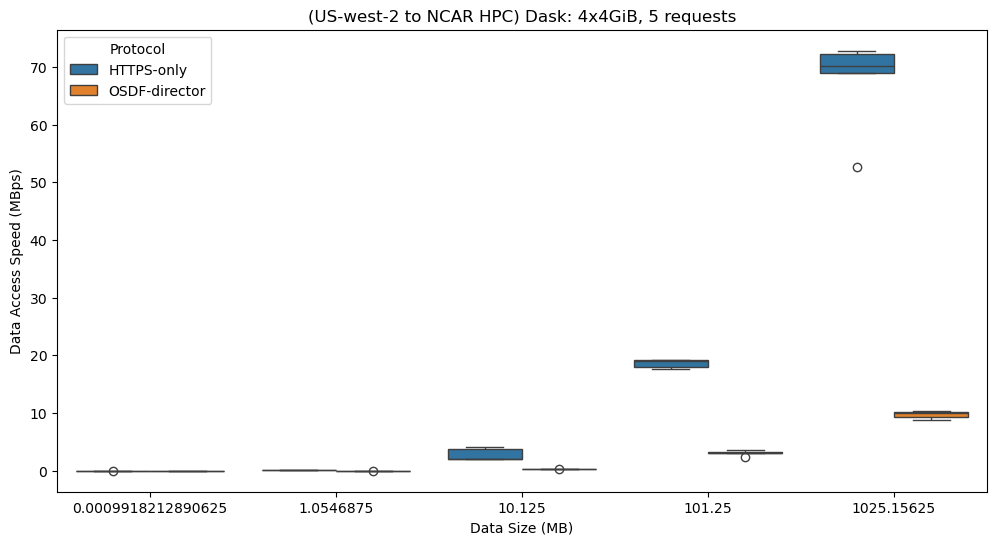

In [38]:
# Convert dataset size to categorical to control the order in the plot
df_diagnostics['dataset_size'] = df_diagnostics['dataset_size'].astype("category")

# Set the order for dataset sizes to appear in ascending order
size_order = sorted(df_diagnostics['dataset_size'].unique())

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_diagnostics, 
    x="dataset_size", 
    y="MBps", 
    hue="protocol", 
    order=size_order
)

# Customize plot appearance
plt.xlabel("Data Size (MB)")
plt.ylabel("Data Access Speed (MBps)")
plt.title("(US-west-2 to NCAR HPC) Dask: 4x4GiB, 5 requests")
plt.legend(title="Protocol")
plt.show()

In [ ]:
###########################################################################

In [ ]:
# #Try using a specific cache
# sdsc_cache='https://sdsc-cache.nationalresearchplatform.org:8443/aws-opendata/us-west-2/ncar-cesm2-lens/atm/monthly/'+\
#             'cesm2LE-historical-smbb-TREFHTMX.zarr'

In [ ]:
# %%time
# test_1 = xr.open_zarr(sdsc_cache).TREFHTMX.isel(time=0)
# test_1